In [51]:
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import os
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Reshape, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
dataset_dir = pathlib.Path('/Users/admin/Downloads/DSGP/Data Set copy')
img_height, img_width = 180,180
batch_size = 16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10261 files belonging to 3 classes.
Using 9235 files for training.


In [53]:
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10261 files belonging to 3 classes.
Using 1026 files for validation.


In [54]:
class_names = train_ds.class_names
print(class_names)

['Over Ripe', 'Ripe', 'Unripe']


In [55]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True,  
)

In [56]:
efficientnet_model = Sequential()

pretrained_m =tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180,180,3),
    pooling=None,
    classes=3,
    classifier_activation="softmax",
)
for layer in pretrained_m.layers:
    layer.trainable = False
    
efficientnet_model.add(pretrained_m)
efficientnet_model.add(BatchNormalization())
efficientnet_model.add(GlobalAveragePooling2D())
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(256, activation='relu'))
efficientnet_model.add(Dropout(0.2))
efficientnet_model.add(Dense(3, activation='softmax'))

In [57]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 6, 6, 2560)        64097687  
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 6, 6, 2560)        10240     
 chNormalization)                                                
                                                                 
 module_wrapper_10 (ModuleW  (None, 2560)              0         
 rapper)                                                         
                                                                 
 module_wrapper_11 (ModuleW  (None, 2560)              0         
 rapper)                                                         
                                                                 
 module_wrapper_12 (ModuleW  (None, 256)              

In [58]:
efficientnet_model.compile(optimizer=LegacyAdam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:

history = efficientnet_model.fit(
    train_ds,  
    epochs=100,   
    validation_data=vali_ds,  
    callbacks=[early_stopping],    
)

Epoch 1/100
578/578 [==============================] - 182s 288ms/step - loss: 4.9192 - accuracy: 0.8410 - val_loss: 7.9875 - val_accuracy: 0.8996
Epoch 2/100
578/578 [==============================] - 120s 206ms/step - loss: 12.3031 - accuracy: 0.8789 - val_loss: 7.6546 - val_accuracy: 0.9259
Epoch 3/100
578/578 [==============================] - 121s 209ms/step - loss: 18.5840 - accuracy: 0.8847 - val_loss: 10.1953 - val_accuracy: 0.9162
Epoch 4/100
578/578 [==============================] - 120s 208ms/step - loss: 22.7021 - accuracy: 0.9027 - val_loss: 15.7531 - val_accuracy: 0.9191
Epoch 5/100
578/578 [==============================] - 122s 210ms/step - loss: 30.6270 - accuracy: 0.9058 - val_loss: 28.4501 - val_accuracy: 0.9444


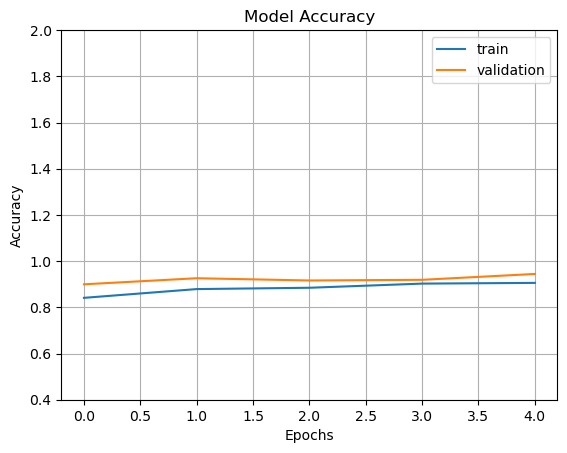

In [60]:
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=2)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

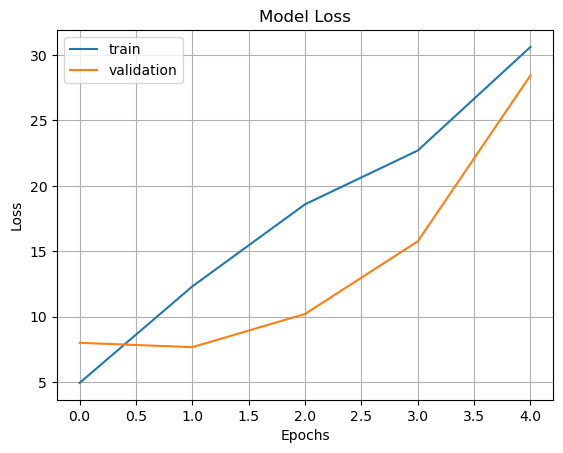

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [74]:
# import cv2
# image=cv2.imread('/Users/admin/Downloads/unripe mango.jpeg')
# image_resized = cv2.resize(image, (img_height, img_width))
# image=np.expand_dims(image_resized,axis=0)
# print(image.shape)

In [75]:
# pred=efficientnet_model.predict(image)
# print(pred)

In [76]:
# output_class = class_names[np.argmax(pred)]
# print("The fruit is a", output_class)

In [107]:
import cv2
def predict_image(model, image_path, class_names):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (img_height, img_width))
    image = np.expand_dims(image_resized, axis=0)

    pred = efficientnet_model.predict(image)
    print(pred)
    confidence_threshold = 0.5
    if np.max(pred) < confidence_threshold:
        return "unknown"
    
    output_class = class_names[np.argmax(pred)]
    return output_class

image_path = '/Users/admin/Downloads/rawban.jpeg'
predicted_class = predict_image(efficientnet_model, image_path, class_names)

print("The fruit is ", predicted_class)

1/1 [==============================] - 0s 119ms/step
[[0.000000e+00 2.416666e-15 1.000000e+00]]
The fruit is  Unripe
